# A Markovian model of evolving world IO network
https://sevamoo.github.io/Markovian_IO_SI_PLOSONE/

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
#import sompy as SOM
from pylab import matshow, savefig
from scipy.linalg import norm
import time

## Supporting Functions

In [2]:
def update_by_momentum(series, span, pred_period):
    result = []  # first value is same as series
    vals = series[-span - 1:]
    for n in range(pred_period):
        momentum_avg = np.mean(np.diff(vals))
        result.append(vals[-1] + momentum_avg)
        vals[-1] = result[-1]

    return result

In [4]:
def aggregate_economy_int_consumptions(WIOT):
    economy_n = 41
    industry_n = 35
    economy_int_consumptions_n = 1
    economy_produsction_costs_n = 1
    states_n = economy_n * industry_n + economy_n * 1 + industry_n * 1

    economy_income = np.zeros((economy_n * industry_n, economy_n))
    economy_int_consumptions = np.zeros((economy_n * industry_n, economy_n))
    ind = economy_n * industry_n
    for i in range(economy_n):
        # This data are stored in the last columns on the right side of WIOD.
        # They are in five subcategory that here we just sum them as the final consumption of the government (inc. households)
        col = i * 5 + ind
        economy_int_consumptions[:, i] = WIOT[:, col:col + 5].sum(axis=1)

    # I don't know why but sometimes it gets a bit negative?!!! due to change in inventory (5th column of economy consum)
    economy_int_consumptions[economy_int_consumptions < 0] = 0

    # This is Tax, Payments, ...
    industry_production_costs = np.around(
        WIOT[:].sum(axis=1) - WIOT[:, :economy_n * industry_n].sum(axis=0), decimals=5)

    return (economy_int_consumptions, industry_production_costs)

In [5]:
def build_markov_chain_Dense(
        Q,
        WIOT,
        economy_n,
        industry_n,
        economy_int_consumptions,
        industry_production_costs,
):
    e0 = time.time()
    eps = .001

    for i in range(0, economy_n * industry_n):

        # For industry interactions
        for j in range(0, economy_n * industry_n):
            Q[i, j] = WIOT[j, i]

        # For payments of industry to its economy: This is the source of income for the economy
        economy_ind_industry = i // industry_n
        Q[i, economy_n * industry_n + economy_ind_industry] = industry_production_costs[i]

        # For economy's costs (i.e. consumptions)
        ind_economy_inTM = economy_n * industry_n

        for j in range(economy_n):
            Q[j + ind_economy_inTM, i] = economy_int_consumptions[i, j]

    # We have row stochastic matrix! In the paper we have column stochastic!
    singular_industries = []
    for i in range(Q.shape[0]):
        s = sum(Q[i])

        if np.sum(Q[i] > 0) == 1:
            if np.where(Q[i] > 0) == i:

                # means absorbing state
                Q[i] = eps
                Q[i, i] = 1.
                s = sum(Q[i])
                Q[i] = np.divide(Q[i], s)
            else:
                pass
            # print(np.where(Q[i] > 0), i, np.sum(Q[:, i] > 0))

        if s == 0:
            singular_industries.append(i % economy_n)
            Q[i] = eps
            Q[i, i] = 1.
            s = sum(Q[i])
            Q[i] = np.divide(Q[i], s)
        else:
            Q[i] = np.divide(Q[i], s)
    print('Making the TM in {} second'.format(time.time() - e0))

    return (np.around(Q, decimals=10), list(np.unique(singular_industries)))

In [6]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

In [7]:
def Kemeny_constant(MC):
    from scipy.linalg import eig
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [8]:
# Sensitivity analysis on a single node
def change_node(M,
                economy_to_perturb=None,
                industry_to_perturb=None,
                percent=10):
    MC = M.copy()
    
    ind_indusrty_to_perturb_from_their_economy = []
    ind_indusrty_to_perturb_from_specific_industry = []

    if industry_to_perturb == industry_n:
        i = industry_n * economy_n + economy_to_perturb
    else:
        i = industry_to_perturb + (economy_to_perturb) * industry_n
        
    MC[i, :] = MC[i, :] * (1 + percent * .01)
    MC[:, i] = MC[:, i] * (1 + percent * .01)
    MC[i, i] = MC[i, i] / (1 + percent * .01)

    for i in range(MC.shape[0]):
        s = sum(MC[i])
        
        if s == 0:
            MC[i] = eps
            MC[i, i] = 1.
            s = sum(MC[i])
            MC[i] = np.divide(MC[i], s)

        else:
            MC[i] = np.divide(MC[i], s)

    return MC

## Load Dataset

In [9]:
economy_n = 41
industry_n = 35
header = pd.read_csv('./markov/Data/WIOD/header.csv', header=None)
economy_names = header.values[1, range(0, 1435, 35)]
industry_names = header.values[0, range(0, 35)]

In [10]:
Countries = pd.read_csv("./markov/Data/WIOD/Economies_Names.csv")

In [11]:
# We calculated this before from the WIOD, for GDP calculations
VA = pd.read_csv('./markov/Data/WIOD/VAs.csv', index_col=[0])

In [12]:
WIO = list()
for i in range(1995, 2012):
    d = pd.read_csv(
        './markov/Data/WIOD/wiot' + str(i) + '_row_apr12.csv', header=[0, 1, 2])
    WIO.append(d.values[:])
    print(i, d.shape)

1995 (1435, 1640)
1996 (1435, 1640)
1997 (1435, 1640)
1998 (1435, 1640)
1999 (1435, 1640)
2000 (1435, 1640)
2001 (1435, 1640)
2002 (1435, 1640)
2003 (1435, 1640)
2004 (1435, 1640)
2005 (1435, 1640)
2006 (1435, 1640)
2007 (1435, 1640)
2008 (1435, 1640)
2009 (1435, 1640)
2010 (1435, 1640)
2011 (1435, 1640)


## Using Power Iteration to calculate the steady state probabilities, Pi

In [13]:
Pi = []
TMs = []
Mixing_times = []
singular_ids = []

for i, WIOT in enumerate(WIO):
    economy_int_consumptions, industry_production_costs = aggregate_economy_int_consumptions(WIOT)
    economy_n = 41
    industry_n = 35
    states_n = economy_n * industry_n + economy_n
    TM = np.zeros((states_n, states_n))
    TM, singular_id = build_markov_chain_Dense(TM, WIOT, economy_n, industry_n,
                                               economy_int_consumptions,
                                               industry_production_costs)
    TMs.append(TM)
    singular_ids.extend(singular_id)
    t, mixing_ = simulate_markov(TM)
    Pi.append(t)
    Mixing_times.append(mixing_)

singular_ids = np.unique(singular_ids)

Making the TM in 1.10203218460083 second
Iterating 290 times in 0.2180018424987793
Making the TM in 1.1010429859161377 second
Iterating 259 times in 0.19900250434875488
Making the TM in 1.1040287017822266 second
Iterating 251 times in 0.1980140209197998
Making the TM in 1.2930006980895996 second
Iterating 259 times in 0.19001245498657227
Making the TM in 1.0739963054656982 second
Iterating 263 times in 0.1400136947631836
Making the TM in 1.0300328731536865 second
Iterating 241 times in 0.1300041675567627
Making the TM in 1.1100044250488281 second
Iterating 228 times in 0.12502431869506836
Making the TM in 1.073000192642212 second
Iterating 228 times in 0.17100024223327637
Making the TM in 1.1069974899291992 second
Iterating 223 times in 0.13200831413269043
Making the TM in 1.1580007076263428 second
Iterating 208 times in 0.16900062561035156
Making the TM in 1.1389970779418945 second
Iterating 190 times in 0.11500740051269531
Making the TM in 1.0869560241699219 second
Iterating 173 time

## Average mixing time of Markov chains as an aggregate index of globalization

In [14]:
# We run the power iteration for several times to see if there are some variations in the mixing time
n = 100
Mixing_times_n_times = np.zeros((n, len(TMs)))
for i in range(n):
    for j in range(len(TMs)):
        t, mixing_ = simulate_markov(TMs[j], verbose='off')
        Mixing_times_n_times[i, j] = mixing_

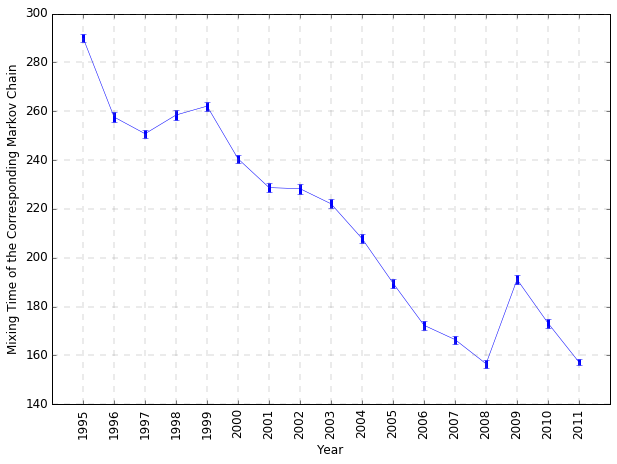

In [17]:
fig = plt.figure(figsize=(10, 7));
yerr = 3 * Mixing_times_n_times.std(axis=0)
plt.errorbar(
    range(1, 18),
    Mixing_times_n_times.mean(axis=0),
    yerr=yerr,
    fmt='-',
    color='b',
    ecolor='b',
    linewidth=.51,
    elinewidth=3)
plt.xticks(range(1, 18), range(1995, 2012))
label = range(1995, 2012)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Mixing Time of the Corresponding Markov Chain')
plt.xlabel('Year')
plt.xticks(range(1, 18), label, rotation=90)

plt.grid(linewidth=.31, color='gray', linestyle='--')
path = './markov/Images/Mixing_Time.tiff'
# fig.savefig(path,dpi=300)
plt.show();
plt.close();

## Kemeny constants of Markov chains as an aggregate index of globalization

In [18]:
Kemenys = []
for TM in TMs:
    K, pi = Kemeny_constant(TM)
    Kemenys.append(K)

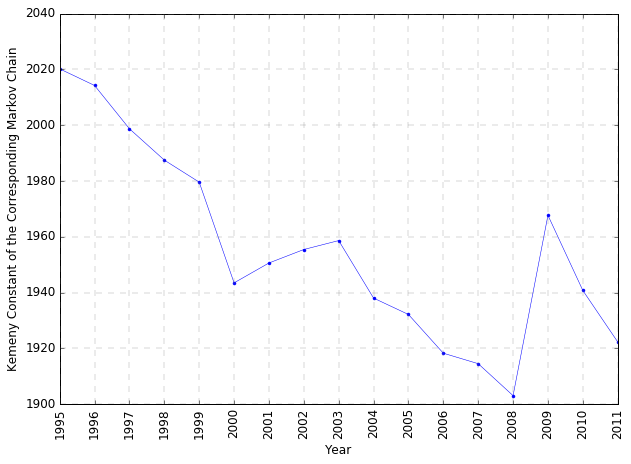

In [19]:
fig = plt.figure(figsize=(10, 7));
plt.plot(Kemenys, '.-b', linewidth=.51)
label = range(1995, 2012)
plt.xticks(range(17), label, rotation=90)
plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Kemeny Constant of the Corresponding Markov Chain')
font = {'size': 12}
plt.rc('font', **font)
path = './markov/Images/Kemeny.tiff'
# fig.savefig(path,dpi=300)
plt.show();
plt.close();

## GDP share of economies (red) compared to aggregated structural power (blue) over time

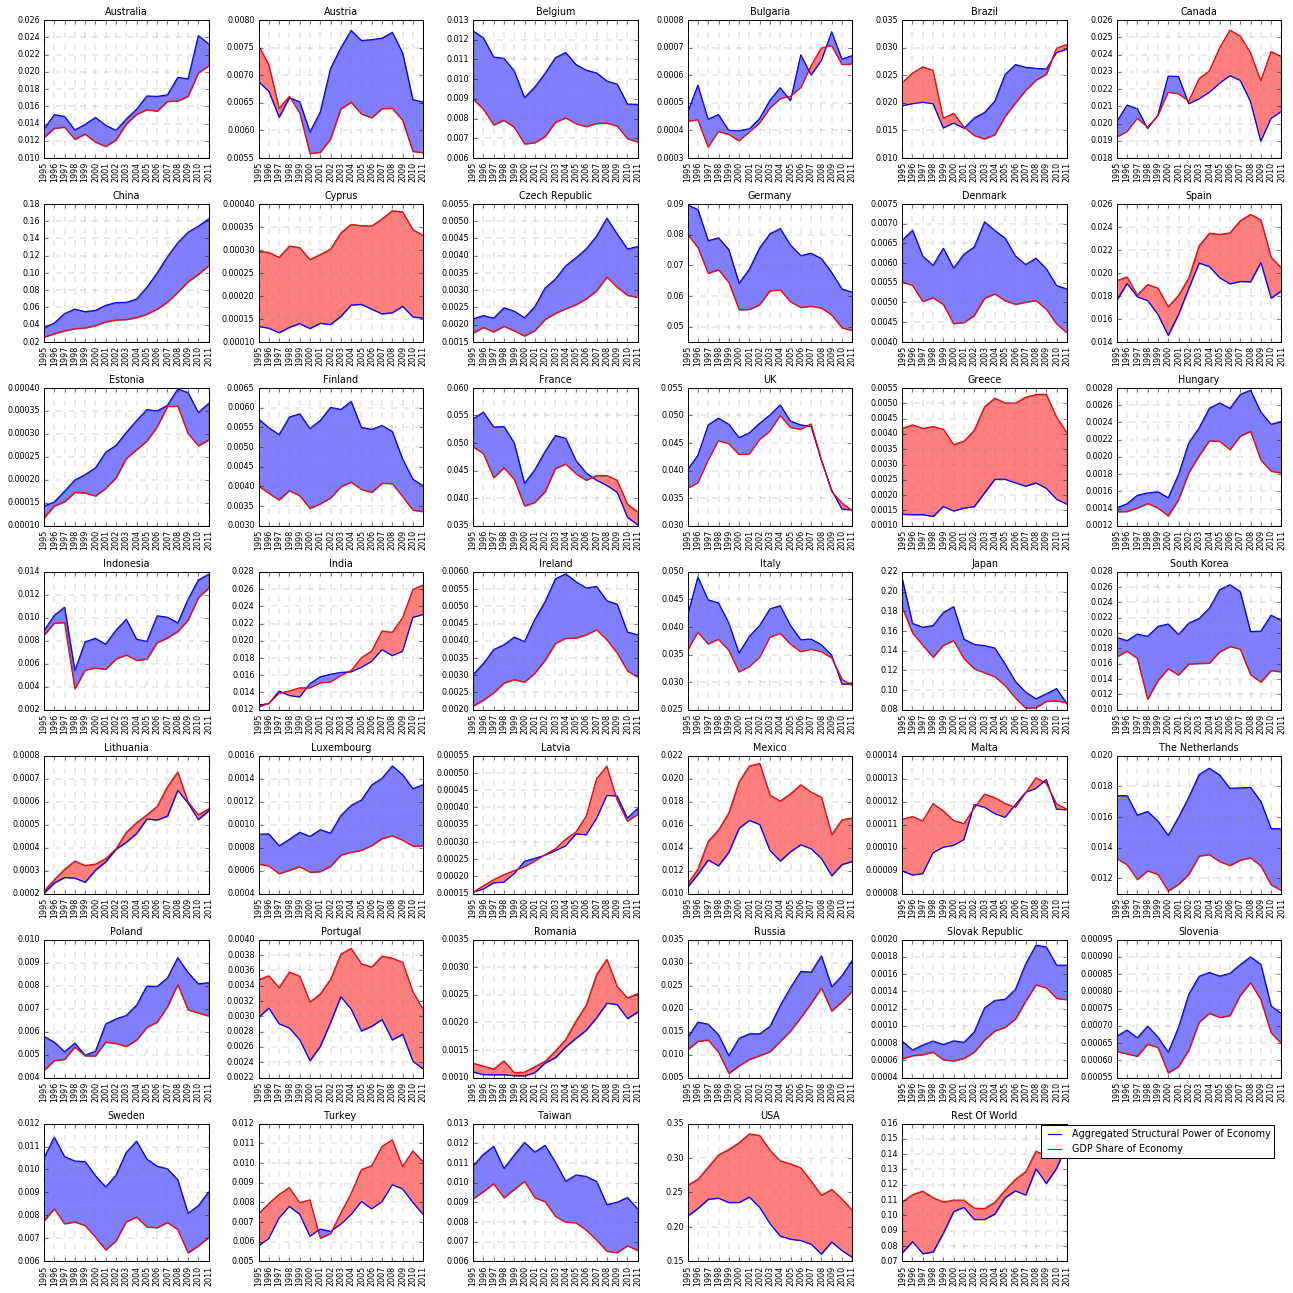

In [20]:
Data_all = np.asarray(Pi).T

fig = plt.figure(figsize=(18, 18))
font = {'size': 8}
plt.rc('font', **font)
GDP_shares = np.zeros((economy_n, 17))
Economies_shares = np.zeros((economy_n, 17))
for i in range(economy_n):
    ind_indusrty = range(i * industry_n, (i + 1) * industry_n)
    GDP_shares[i] = VA.values[:, ind_indusrty].sum(axis=1) / VA.values[:].sum(
        axis=1)

    plt.subplot(7, 6, i + 1)
    plt.title(Countries.Country[i])
    ind_indusrty = list(range(i * industry_n,
                         (i + 1) * industry_n)) + [industry_n * economy_n + i]
    Economies_shares[i] = Data_all[ind_indusrty].T.sum(axis=1)

    plt.plot(
        range(17),
        Economies_shares[i],
        '-b',
        linewidth=1.2,
        label='Aggregated Structural Power of Economy');
    plt.plot(
        range(17),
        GDP_shares[i],
        '-r',
        linewidth=1.2,
        label='GDP Share of Economy');
    y1 = Economies_shares[i]
    y2 = GDP_shares[i]
    x = range(17)

    plt.fill_between(
        x, y1, y2, where=y2 >= y1, facecolor='red', alpha=.5, interpolate=True)
    plt.fill_between(
        x, y1, y2, where=y2 <= y1, facecolor='blue', alpha=.5, interpolate=True)
    path = './markov/Images/GDP_Share_Pi.tiff'
    label = range(1995, 2012)
    plt.xticks(range(17), label, rotation=90)

    plt.tight_layout()

    plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.legend(bbox_to_anchor=(2.29, 1.022))
# fig.savefig(path,dpi=300)
plt.show();
plt.close();

## Predicted trends of structural potential of different economies

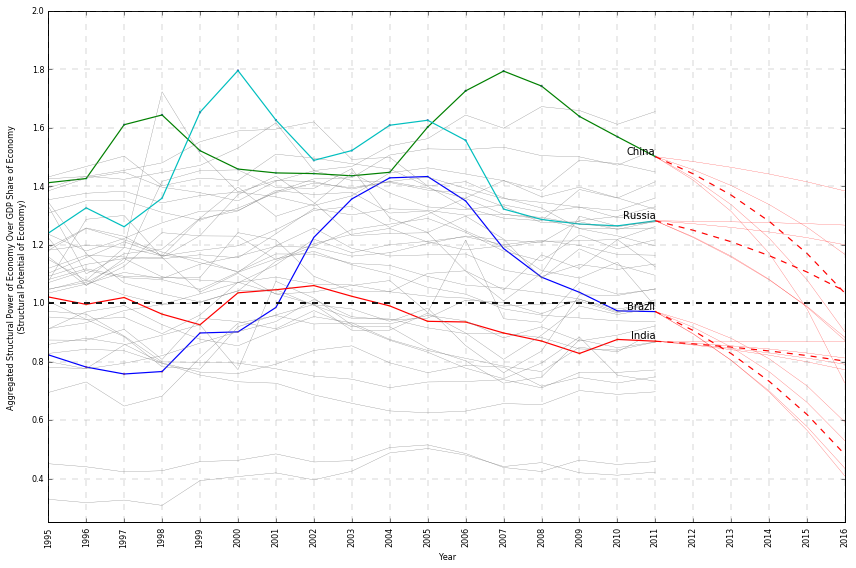

In [21]:
fig = plt.figure(figsize=(12, 8))

min_x = np.min(Economies_shares[:, :] / GDP_shares[:, :])
min_y = np.min(GDP_shares[:, :])

max_x = np.max(Economies_shares[:, :] / GDP_shares[:, :])
max_y = np.max(GDP_shares[:, :])
eps = .02

for c in range(economy_n):

    x = Economies_shares[c, :]
    color = Economies_shares[c, :] / GDP_shares[c, :]
    x = range(17)
    y = GDP_shares[c, :]
    y = Economies_shares[c, :]
    y = Economies_shares[c, :] / GDP_shares[c, :]

    min_x = np.min(Economies_shares[c, :])
    min_y = np.min(GDP_shares[c, :])
    min_min = np.min([min_x, min_y])

    max_x = np.max(Economies_shares[c, :])
    max_y = np.max(GDP_shares[c, :])
    max_max = np.max([max_x, max_y])
    eps = .02

    ax = plt.gca()
    pred_period = 5
    col = 0
    if Countries.Country[c] in ["Brazil", "Russia", "China", "India"]:
        ax.plot(x, y, '-', linewidth=1.2)

        all_preds = []
        for span in range(3, 7):
            series = y.copy()

            y_pred = update_by_momentum(series, span, pred_period)
            all_preds.append(y_pred)
            y_pred = list(y[-1:]) + y_pred
            x_pred = list(x[-1:]) + list(range(17, 17 + pred_period))
            ax.plot(x_pred, y_pred, '-r', linewidth=0.2)
        y_pred = list(y[-1:]) + list(np.median(all_preds, axis=0))
        x_pred = list(x[-1:]) + list(range(17, 17 + pred_period))
        ax.plot(x_pred, y_pred, '--r', linewidth=1.2)

        ax.scatter(
            x,
            y,
            vmax=1.7,
            vmin=0.5,
            c=color,
            s=20,
            marker='.',
            edgecolor='None',
            cmap='RdYlBu',
            alpha=1)
        ax.annotate(
            Countries.Country[c],
            size=10,
            xy=(x[16], y[-1] + .002),
            xytext=(0, 0),
            textcoords='offset points',
            ha='right',
            va='bottom')
    else:
        ax.plot(x, y, 'gray', linewidth=.3)

    ax.plot([0, 16 + pred_period], [1, 1], '--k', linewidth=.2)

    plt.ylim([.25, 2])
    plt.xlim([0, 16 + pred_period])

    plt.ylabel(
        'Aggregated Structural Power of Economy Over GDP Share of Economy\n (Structural Potential of Economy)'
    )
    plt.xlabel('Year')
    plt.xticks(
        range(17 + pred_period),
        range(1995, 2012 + pred_period),
        rotation='vertical')

    plt.grid(linewidth=.31, color='gray', linestyle='--')
    plt.tight_layout()
    font = {'size': 10}
    plt.rc('font', **font)
    path = './markov/Images/GDP_Share_Vs_Pi_Share_trend.tiff'

# fig.savefig(path,dpi=300)
plt.show();
plt.close();

## The effect of 99% slowdown of electrical and optical equipment industry of China

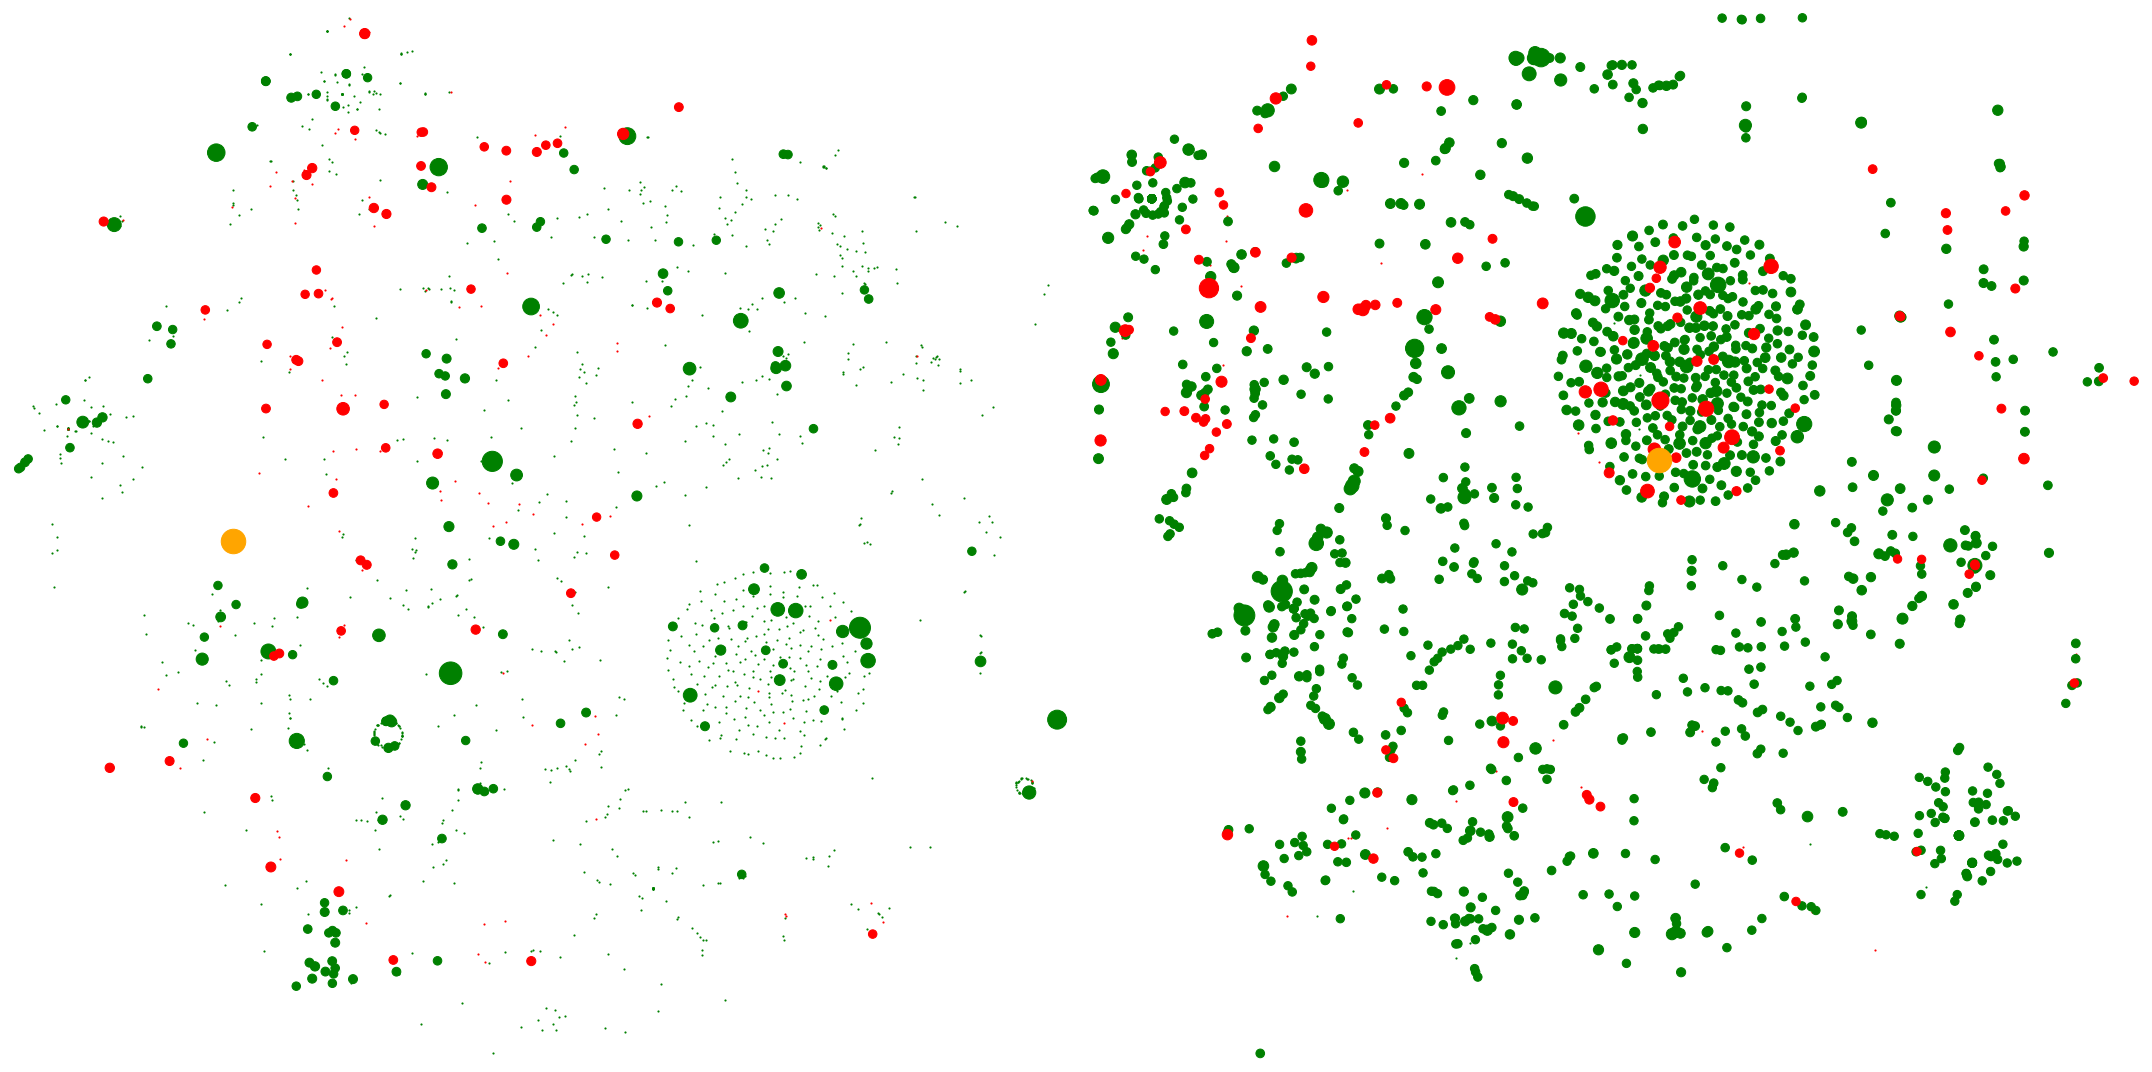

In [22]:
fig = plt.figure(figsize=(30, 15))

for i, year in enumerate([1995, 2011]):
    plt.subplot(1, 2, i + 1)
    whichvector = 'Export'
    whichyearnetwork = year
    pct_change_range = 1.0
    economyname = 'China'
    industryname = 'Electrical and Optical Equipment'

    pi_perturbedpath = "./markov/Data/perturb/pi_perturbed_How_much_change_-99_year_" + str(
        whichyearnetwork) + ".csv"
    pi_perturbed = pd.read_csv(pi_perturbedpath, index_col=0)

    pi_normalpath = "./markov/Data/perturb/pi_normal_How_much_change_-99_year_" + str(
        whichyearnetwork) + ".csv"
    pi_normal = pd.read_csv(pi_normalpath, index_col=0)

    pi_diff_path = "./markov/Data/perturb/PerturbationOnIndustries_Change_PCT_How_much_change_-99_year_" + str(
        whichyearnetwork) + ".csv"
    pi_diff = pd.read_csv(pi_diff_path, index_col=0)

    pi_diff = pi_diff.loc[str(economyname + '-' + industryname)].values[:1435]
    perturbed = pi_perturbed.loc[str(
        economyname + '-' + industryname)].values[:1435]
    normal = pi_normal.values[0, :1435]

    path = "./markov/Data/perturb/Economy_map_" + whichvector + "_" + str(
        whichyearnetwork) + ".json"
    #now assume we have it
    import json
    with open(path) as data_file:
        data = json.load(data_file)
    NETWORK_RESULTS = data
    NETWORK_RESULTS = data
    NETWORK_RESULTS['pi_perturbed'] = list(perturbed * 1e4)
    NETWORK_RESULTS['pi_normal'] = list(normal * 1e4)
    NETWORK_RESULTS['pi_diff'] = list(pi_diff)

    ind_industry = set(
        np.where(np.asarray(NETWORK_RESULTS['industry']) == industryname)[0])
    ind_economy = set(
        np.where(np.asarray(NETWORK_RESULTS['economy']) == economyname)[0])
    indmainnode = list(ind_industry.intersection(ind_economy))[0]

    indsmall = np.where(
        np.abs(np.asarray(NETWORK_RESULTS['pi_diff'])) < pct_change_range)[0]
    indsmed = np.where(
        np.abs(np.asarray(NETWORK_RESULTS['pi_diff'])) >= pct_change_range)[0]

    x = np.asarray(NETWORK_RESULTS['XCoord'])[indsmall]
    y = 1000 - np.asarray(NETWORK_RESULTS['YCoord'])[indsmall]
    vals = np.asarray(NETWORK_RESULTS['pi_diff'])[indsmall]

    plt.scatter(x[vals >= 0], y[vals >= 0], s=1.3, color='g')
    plt.scatter(x[vals < 0], y[vals < 0], s=1.3, color='r')

    x = np.asarray(NETWORK_RESULTS['XCoord'])[indsmed]
    y = 1000 - np.asarray(NETWORK_RESULTS['YCoord'])[indsmed]
    vals = np.asarray(NETWORK_RESULTS['pi_diff'])[indsmed]
    size = 70 + 3 * np.asarray(NETWORK_RESULTS['pi_normal']) / 1 * (
        1 + np.asarray(NETWORK_RESULTS['pi_diff']) / 100)
    size = size[indsmed]

    plt.scatter(x[vals >= 0], y[vals >= 0], s=size[vals >= 0], color='g')
    plt.scatter(x[vals < 0], y[vals < 0], s=size[vals < 0], color='r')

    plt.scatter(
        np.asarray(NETWORK_RESULTS['XCoord'])[indmainnode],
        1000 - np.asarray(NETWORK_RESULTS['YCoord'])[indmainnode],
        s=[600],
        color='orange')

    plt.xlim(-11, 1011)
    plt.ylim(-11, 1011)
    plt.axis('off')
    plt.tight_layout()

path = './markov/Images/perturb_china.tiff'
#fig.savefig(path,dpi=400)
plt.show();
plt.close();

## Systemic fragility vs. systemic influence of each industry for the year 2011

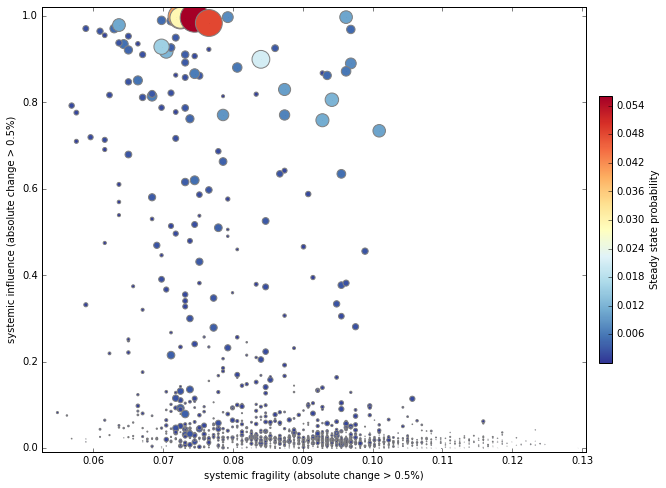

In [23]:
whichyearnetwork = 2011
How_much_change = -99

pi_perturbedpath = "./markov/Data/perturb/pi_perturbed_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_perturbed = pd.read_csv(pi_perturbedpath, index_col=0)

pi_normalpath = "./markov/Data/perturb/pi_normal_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_normal = pd.read_csv(pi_normalpath, index_col=0)

pi_diff_path = "./markov/Data/perturb/PerturbationOnIndustries_Change_PCT_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_diff = pd.read_csv(pi_diff_path, index_col=0)

# Threshold of change in pct
thresh = .5

dim = pi_diff.shape[1]

# Systemic Influence
no_of_pos_affecting = (pi_diff.values[:dim, :dim] > thresh).sum(axis=1)
no_of_neg_affecting = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=1)

ind_pos_affecting = pi_diff.values[:dim, :dim] > thresh
ind_neg_affecting = pi_diff.values[:dim, :dim] < -1 * thresh
pos_affecting = np.zeros(dim)
neg_affecting = np.zeros(dim)
for i in range(dim):
    pos_affecting[i] = pi_diff.values[i, ind_pos_affecting[i]].dot(
        pi_normal.values[0, :dim][ind_pos_affecting[i]])
    neg_affecting[i] = pi_diff.values[i, ind_neg_affecting[i]].dot(
        pi_normal.values[0, :dim][ind_neg_affecting[i]])

# We want to take out the effect each node on itself
self_change = np.diag(pi_diff.values[:, :dim]) * pi_normal.values[0, :dim]

sum_of_affecting = np.abs(neg_affecting) + pos_affecting - np.abs(self_change)
pi_norm = pi_normal.values[0, :dim]

systemic_influence = (no_of_pos_affecting + no_of_neg_affecting) / float(dim)

# Systemic Fragility
no_of_pos_affected = (pi_diff.values[:dim, :dim] > thresh).sum(axis=0)
no_of_neg_affected = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=0)

ind_pos_affected = pi_diff.values[:dim, :dim] > thresh
ind_neg_affected = pi_diff.values[:dim, :dim] < -1 * thresh
pos_affected = np.zeros(dim)
neg_affected = np.zeros(dim)

for i in range(dim):
    pos_affected[i] = pi_diff.values[ind_pos_affected[:dim, i],
                                     i].sum() * pi_normal.values[0, i]
    neg_affected[i] = pi_diff.values[ind_neg_affected[:dim, i],
                                     i].sum() * pi_normal.values[0, i]

systemic_fragility = (no_of_pos_affected + no_of_neg_affected) / float(dim)

sum_of_affected = np.abs(neg_affected) + pos_affected - np.abs(self_change)

fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)

ax = plt.gca()

x = systemic_fragility
y = systemic_influence

p = ax.scatter(
    x,
    y,
    c=pi_norm,
    s=pi_norm[:dim] * 15000,
    marker='o',
    edgecolor='gray',
    cmap=plt.cm.RdYlBu_r,
    alpha=1)

plt.plot(x, y, 'ob', markersize=.3, alpha=.05)

plt.xlabel('systemic fragility (absolute change > {}%)'.format(thresh))
plt.ylabel('systemic influence (absolute change > {}%)'.format(thresh))

cb = plt.colorbar(p, shrink=.6, pad=.02)
cb.set_label('Steady state probability')

eps = .022
xmin = x.min() - eps * .1
xmax = x.max() + eps * .05

ymin = y.min() - eps * .4
ymax = y.max() + eps

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

path = './markov/Images/Fragility_Influence.tiff'
# fig.savefig(path, dpi=300)

plt.show();
plt.close();

## Paradoxical effects of slowing down the activity of economic nodes on Kemeny constant

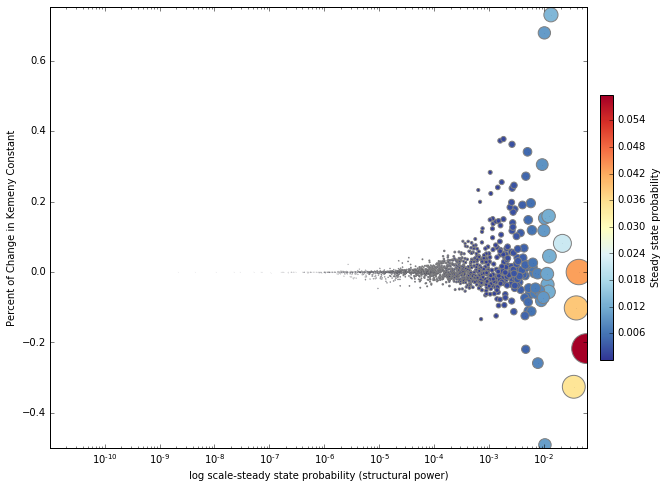

In [41]:
%matplotlib inline
#KEMENY CHNAGE
whichyearnetwork = 2010
How_much_change = -99

Kemeny_Change_PCTpath = "./markov/Data/perturb/Kemeny_Change_PCT_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
Kemeny_Change_PCT = pd.read_csv(Kemeny_Change_PCTpath, index_col=0)

pi_normalpath = "./markov/Data/perturb/pi_normal_How_much_change_" + str(
    How_much_change) + "_year_" + str(whichyearnetwork) + ".csv"
pi_normal = pd.read_csv(pi_normalpath, index_col=0)

#Threshold of change in pct
thresh = .5

dim = pi_normal.shape[1]
pi_norm = pi_normal.values[0, :dim]

fig = plt.figure(figsize=(10, 7))
plt.subplot(1, 1, 1)

ax = plt.gca()
ax.set_xscale('log')

x = pi_norm
y = Kemeny_Change_PCT.values[:dim]

p = ax.scatter(
    x,
    y,
    c=pi_norm,
    s=pi_norm[:dim] * 15000,
    marker='o',
    edgecolor='gray',
    cmap=plt.cm.RdYlBu_r,
    alpha=1)


plt.plot(x, y, 'ob', markersize=.3, alpha=.099)

plt.xlabel('log scale-steady state probability (structural power)')
plt.ylabel('Percent of Change in Kemeny Constant')

cb = plt.colorbar(p, shrink=.6, pad=.02)
cb.set_label('Steady state probability')

eps = .022
xmin = x.min()
xmax = x.max() + eps * .05

ymin = y.min() - eps * .4
ymax = y.max() + eps

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

font = {'size': 14.}

plt.rc('font', **font)
plt.tight_layout()

path = './markov/Images/Kemeny_Eigen.tiff'
#fig.savefig(path, dpi=300)

plt.show();
plt.close();